**About the dataset**

The dataset has totally voices of 24 different actors in different emotions. The file name of person represents the type of emotion they express while speaking. for example for file name of "03-01-01-01-01-01-01.wav" , 
1. The 03 represents only recording
2. Then "01" for speech spoken through the mouth or "02" for speech spoken through the nose
3. Emotional intensity which varies from 01 - neutral to 05 - high level of intensity.
4. Represents the type of statement in the audio
5. Represents the repetition number of statement, since each person says the same word in different emotion.
6. actor ID who recorded the speech sample which ranges from 01 to 24.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

why we extract MFCC, CHROMA, MEL

1. MFCC:- They capture the spectral envelope of the signal, which is useful for speech and speaker recognition(helps in analysing speaker identity)
2. CHROMA:- used for speech classification.
3. MEL spectrogram:- used for speech recognition(it represents the spectral conntent of a sound which can be used for energy distribution)

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

Creating a dictionary of emotions to map the emotion from dataset and 
observed_emotions that contains the emotions of interest for a particular analysis

In [ ]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

function("load data") loads the audio files from the dataset and loops over it to find it's "observed_emotions" and the data is divided in the ratio of 75:25 to test the data

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]#modality-emotional_intensity-repetition_actorID_fileID.wav
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [ ]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [ ]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


Deep learning

**1. MLP**

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Train the model2
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
#Predict for the test set
y_pred=model.predict(x_test)

In [ ]:
y_pred

array(['calm', 'calm', 'calm', 'happy', 'disgust', 'calm', 'happy',
       'fearful', 'fearful', 'happy', 'happy', 'disgust', 'happy',
       'fearful', 'disgust', 'fearful', 'happy', 'calm', 'disgust',
       'calm', 'calm', 'disgust', 'disgust', 'calm', 'disgust', 'fearful',
       'disgust', 'disgust', 'fearful', 'calm', 'disgust', 'disgust',
       'disgust', 'happy', 'disgust', 'calm', 'calm', 'fearful', 'calm',
       'calm', 'calm', 'fearful', 'happy', 'happy', 'fearful', 'calm',
       'fearful', 'fearful', 'calm', 'calm', 'fearful', 'fearful',
       'happy', 'fearful', 'happy', 'fearful', 'disgust', 'calm', 'calm',
       'disgust', 'disgust', 'fearful', 'disgust', 'calm', 'disgust',
       'fearful', 'disgust', 'fearful', 'fearful', 'fearful', 'fearful',
       'fearful', 'fearful', 'fearful', 'disgust', 'fearful', 'fearful',
       'calm', 'calm', 'fearful', 'happy', 'calm', 'happy', 'calm',
       'fearful', 'fearful', 'calm', 'fearful', 'fearful', 'happy',
       'fearful

In [ ]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 72.92%


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
f1_score(y_test, y_pred,average=None)

array([0.8411215 , 0.68041237, 0.69387755, 0.68292683])

In [ ]:
import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(5)

,Actual,Predicted
0,calm,calm
1,calm,calm
2,calm,calm
3,happy,happy
4,disgust,disgust


In [ ]:
with open('mlp_classifier.pkl', 'wb') as file:
    pickle.dump(model, file)

Checking with one audio file - MLP

In [ ]:
filename = '/content/mlp_classifier.pkl'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage

feature=extract_feature("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_02/03-01-01-01-01-01-02.wav", mfcc=True, chroma=True, mel=True)

feature=feature.reshape(1,-1)

prediction=loaded_model.predict(feature)
prediction

array(['disgust'], dtype='<U7')

**2. LSTM**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

This part of code involves finding what type of dataset it is(angry, sad etc) and appending it to a array called labels

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
for i in range(0,5):    
    print(paths[i])

/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_back_happy.wav
/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_bar_happy.wav
/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_cab_happy.wav
/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_calm_happy.wav
/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_bean_happy.wav


In [ ]:
for i in range(0,5):    
    print(labels[i])

happy
happy
happy
happy
happy


In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/TESS Toronto emotional ...,happy
1,/content/drive/MyDrive/TESS Toronto emotional ...,happy
2,/content/drive/MyDrive/TESS Toronto emotional ...,happy
3,/content/drive/MyDrive/TESS Toronto emotional ...,happy
4,/content/drive/MyDrive/TESS Toronto emotional ...,happy


Functions to display the Waveform and Spectrogram of the given data

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

Display the Waveform and Spectrogram of each emotions to know how it differs 

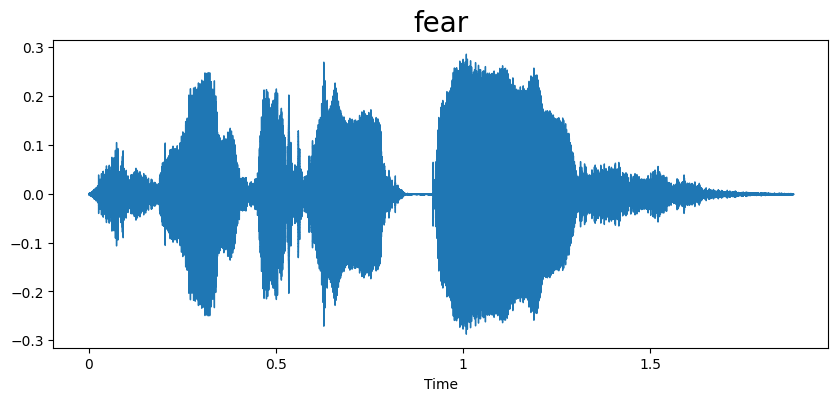

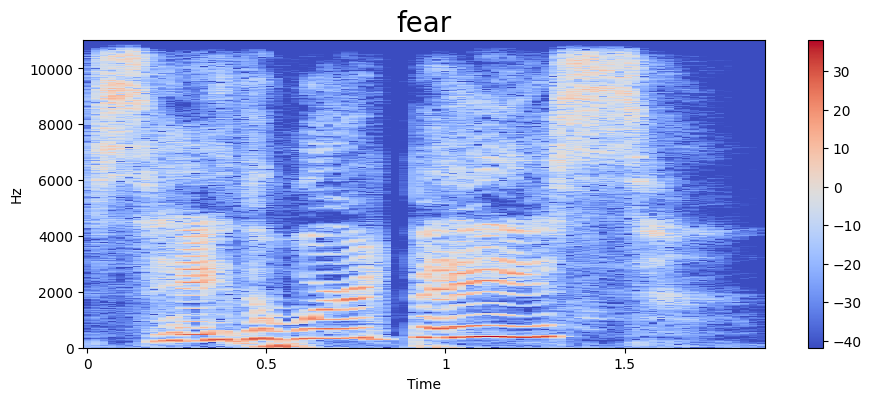

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

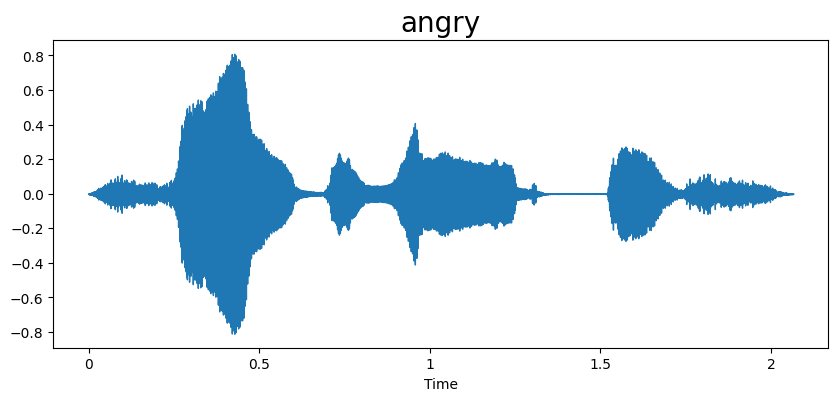

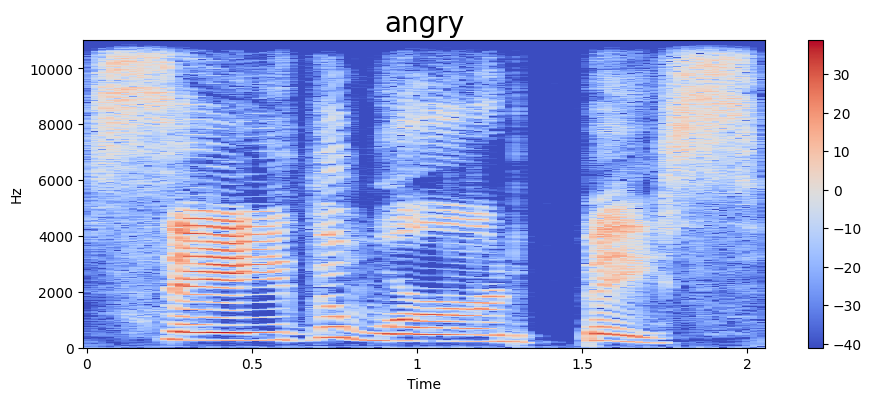

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

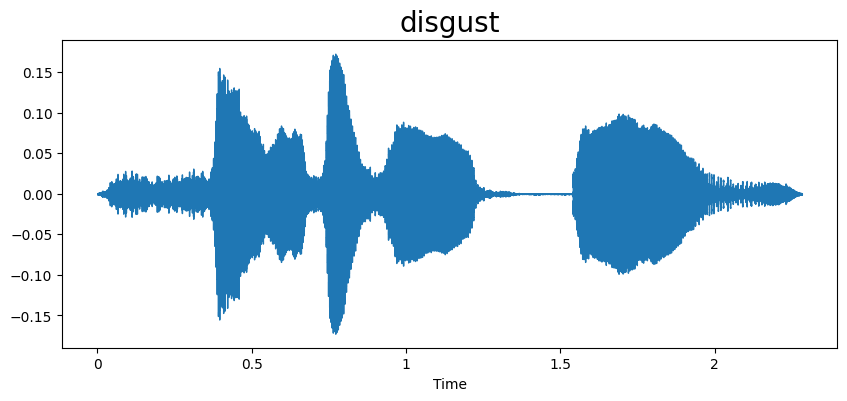

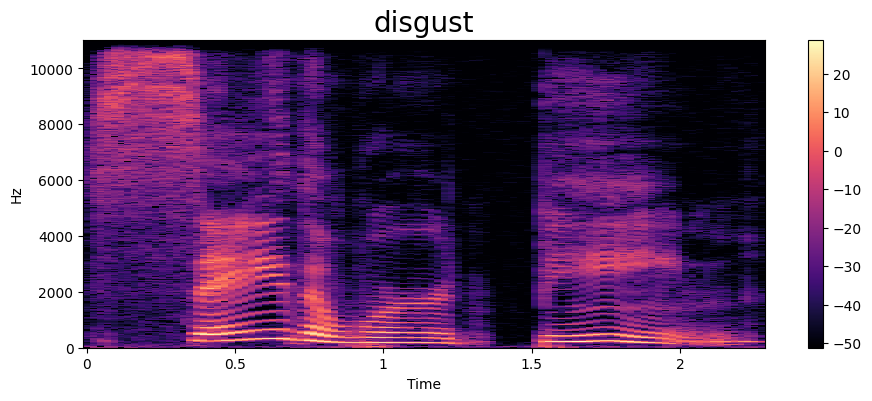

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

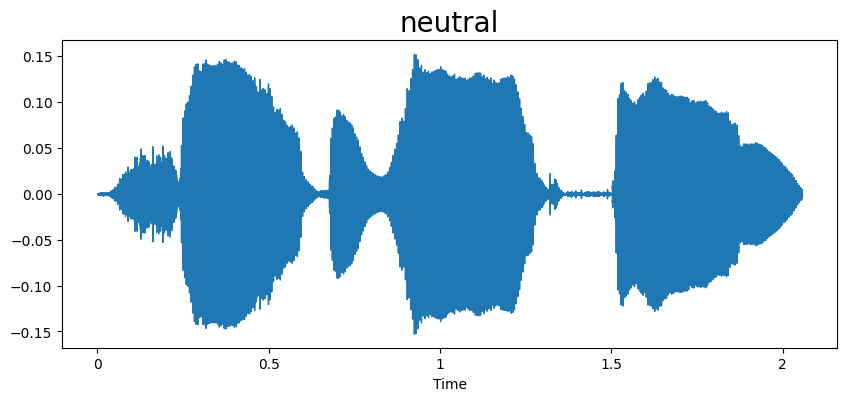

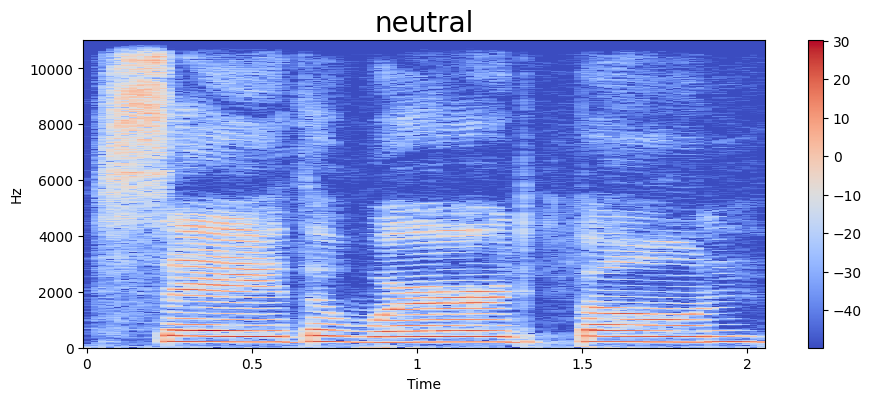

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

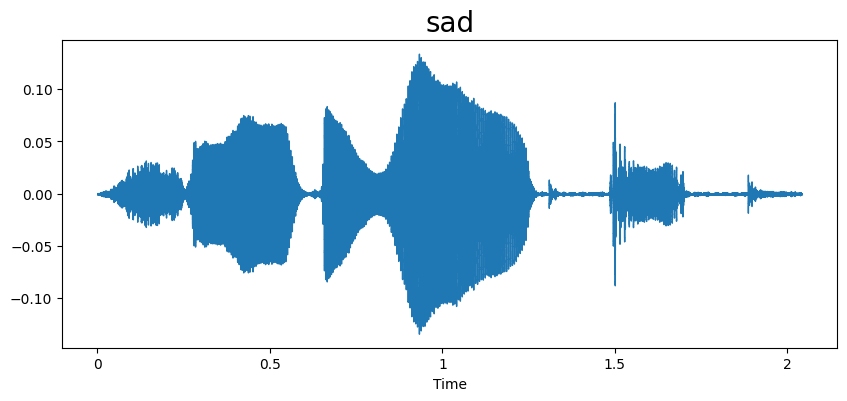

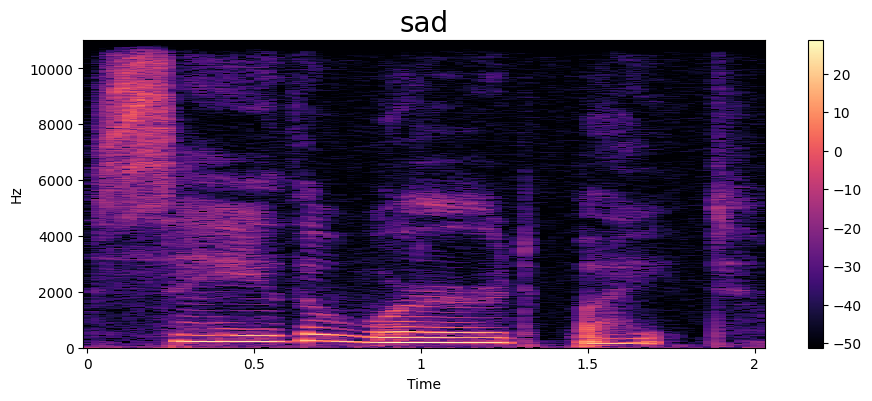

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

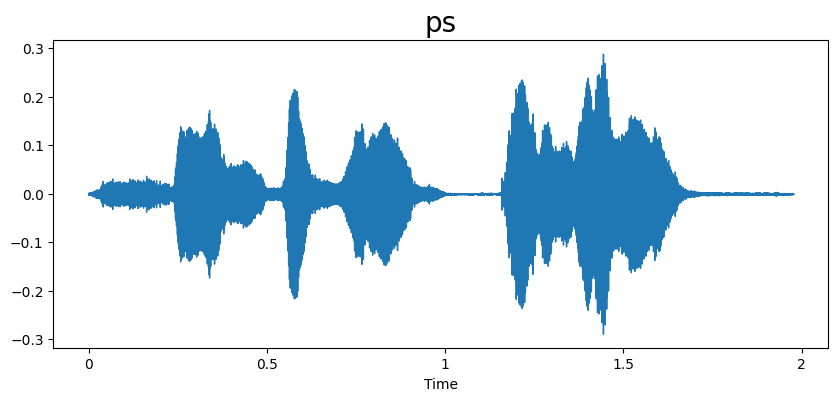

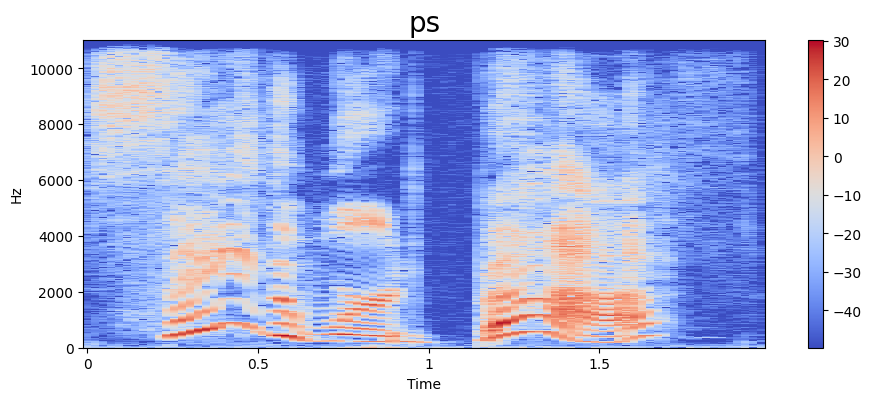

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

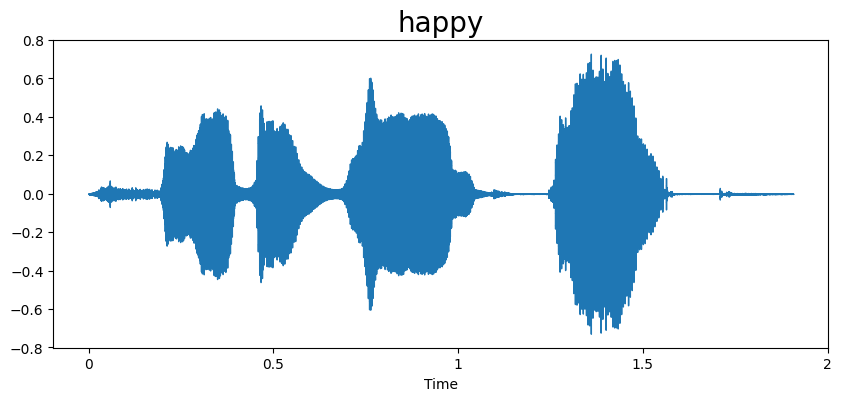

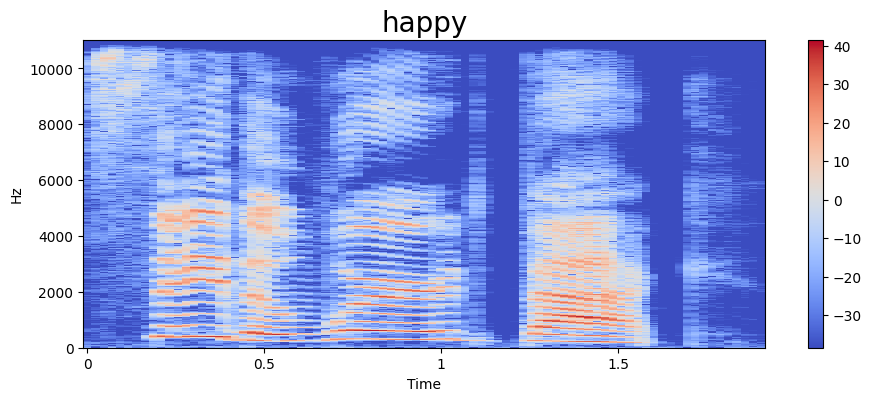

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

**Feature extraction**

function to extract MFCC(Mel-Frequency Cepstral Coefficients) from the audio dataset

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

Extracting the feature from every audio file 

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

0       [-313.00983, 53.21444, -34.822056, 13.387449, ...
1       [-290.17346, 72.863945, -38.194107, 6.1777344,...
2       [-283.61688, 55.235004, -30.87023, 17.27074, -...
3       [-308.12158, 61.8501, -18.209885, 8.136708, -1...
4       [-325.60648, 57.70321, 10.052183, 39.220478, 9...
                              ...                        
5595    [-431.3118, 114.33447, 23.752438, 0.1923666, 1...
5596    [-463.48773, 99.21175, 25.25579, 5.4090886, 17...
5597    [-499.05136, 121.57547, 29.501469, -14.094628,...
5598    [-427.32526, 97.908775, 10.194952, 7.9185, 17....
5599    [-434.40198, 87.961235, 24.93598, 8.945643, 27...
Name: speech, Length: 5600, dtype: object

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [ ]:
## input split
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
y = y.toarray()

Create the LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(123, return_sequences=False, input_shape=(40,1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense_1 (Dense)             (None, 64)                7936      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71,747
Trainable params: 71,747
Non-trai

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
9/9 [==============================] - 9s 469ms/step - loss: 1.8365 - accuracy: 0.3036 - val_loss: 1.7223 - val_accuracy: 0.3295
Epoch 2/100
9/9 [==============================] - 3s 336ms/step - loss: 1.5452 - accuracy: 0.4241 - val_loss: 1.4692 - val_accuracy: 0.3634
Epoch 3/100
9/9 [==============================] - 4s 416ms/step - loss: 1.2509 - accuracy: 0.5067 - val_loss: 1.0858 - val_accuracy: 0.5214
Epoch 4/100
9/9 [==============================] - 4s 423ms/step - loss: 0.9304 - accuracy: 0.6469 - val_loss: 0.7801 - val_accuracy: 0.6580
Epoch 5/100
9/9 [==============================] - 3s 308ms/step - loss: 0.6864 - accuracy: 0.7547 - val_loss: 0.6010 - val_accuracy: 0.7205
Epoch 6/100
9/9 [==============================] - 3s 372ms/step - loss: 0.4856 - accuracy: 0.8496 - val_loss: 0.4972 - val_accuracy: 0.7455
Epoch 7/100
9/9 [==============================] - 3s 392ms/step - loss: 0.3607 - accuracy: 0.8900 - val_loss: 0.3733 - val_accuracy: 0.8527
Epoch 8/100
9

Plot the results

In [ ]:
model.save('lstm_model_SLP.h5')

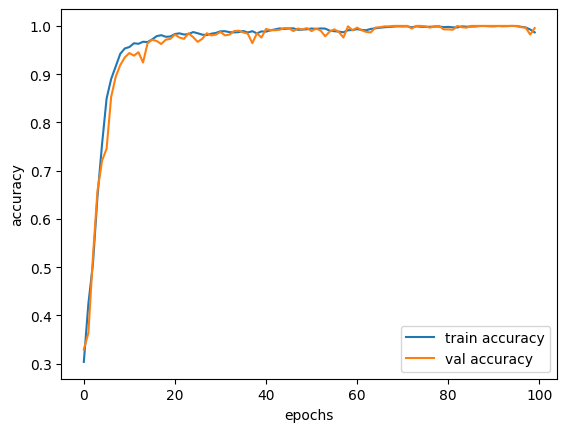

In [ ]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Checking with one audio file - LSTM

In [ ]:
!pip install pushbullet.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1/1 [==============================] - 1s 807ms/step
Predicted class: ['sad']


**3. CNN**

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
model_2 = Sequential()
model_2.add(Conv1D(64,5,padding = 'same',input_shape=(40,1)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.2))
model_2.add(Flatten())
model_2.add(Dense(7))
model_2.add(Activation('softmax'))

In [ ]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40, 64)            384       
                                                                 
 activation_6 (Activation)   (None, 40, 64)            0         
                                                                 
 dropout_5 (Dropout)         (None, 40, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0         
                                                                 
 dense_6 (Dense)             (None, 7)                 17927     
                                                                 
 activation_7 (Activation)   (None, 7)                 0         
                                                                 
Total params: 18,311
Trainable params: 18,311
Non-trai

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(X, y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
9/9 [==============================] - 0s 56ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0028 - val_accuracy: 0.9991
Epoch 2/100
9/9 [==============================] - 0s 49ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.0014 - val_accuracy: 0.9991
Epoch 3/100
9/9 [==============================] - 0s 46ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 4/100
9/9 [==============================] - 0s 44ms/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 0.0030 - val_accuracy: 0.9991
Epoch 5/100
9/9 [==============================] - 0s 44ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 0.9991
Epoch 6/100
9/9 [==============================] - 0s 47ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.0018 - val_accuracy: 0.9991
Epoch 7/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0012 - val_accuracy: 0.9991
Epoch 8/100
9/9 [===

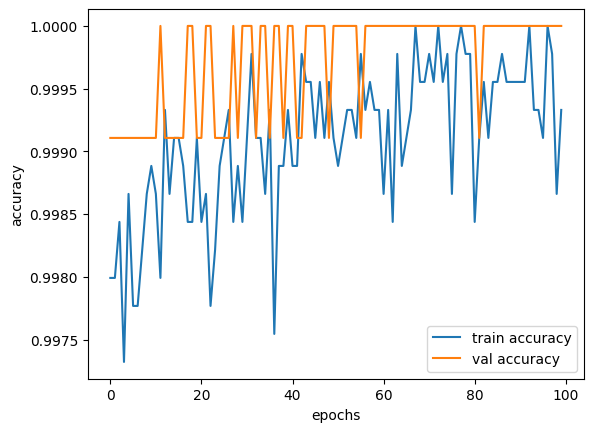

In [ ]:
epochs = list(range(100))
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**Testing of the model**

In [ ]:
!apt-get install -y portaudio19-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 188 kB of archives.
After this operation, 926 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudiocpp0 amd64 19.6.0-1build1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 portaudio19-dev amd64 19.6.0-1build1 [106 kB]
Fetched 188 kB in 1s (277 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../libportaudio

In [ ]:
!pip install pyaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyAudio-0.2.13.tar.gz (46 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyaudio: filename=PyAudio-0.2.13-cp39-cp39-linux_x86_64.whl size=68686 sha256=6921f770af595b8c2b995331be42e7f2e4a1c522da576ccbc4355210a273bbf5
  Stored in directory: /root/.cache/pip/wheels/d5/52/ae/fa7c92aa6e9f30fc009f4f5d7caf459fad3610f0a4022cf12a
Successfully built pyaudio


In [ ]:
!pip install sounddevice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install virtual-audio-capture

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement virtual-audio-capture (from versions: none)
ERROR: No matching distribution found for virtual-audio-capture


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from pushbullet import Pushbullet

model = tf.keras.models.load_model('/content/lstm_model_SLP.h5')

# Load the audio file
filename = '/content/drive/MyDrive/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav'
audio, sample_rate = librosa.load(filename, sr=22050, mono=True, duration=5)

# Extract features
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
features = np.mean(mfccs.T,axis=0)

# Reshape the features to match the expected input shape of the model
features = features.reshape(1, -1)

# Predict the label for the audio file
predicted_class = model.predict(features)
predicted_class_name = enc.inverse_transform(predicted_class)

print("Predicted class:", predicted_class_name[0])

if(predicted_class_name[0] == "sad"):
  API_KEY = "o.z0RIUOR99iHWkJ2GMg4mciGYbJzSQAuN"
  pb = Pushbullet(API_KEY)
  text = "your children seems to be sad in her conversation please take care of your children"
  push = pb.push_note("Sadness Detected",text)


1/1 [==============================] - 1s 781ms/step
Predicted class: ['sad']
